# Convolutional Networks
So far we have worked with deep fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

First you will implement several layer types that are used in convolutional networks. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

In [2]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from deeplearning.classifiers.cnn import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from deeplearning.layers import *
from deeplearning.fast_layers import *
from deeplearning.solver import Solver
import random 
import torch
seed = 7
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print ('%s: ' % k, v.shape)

deeplearning/datasets/cifar-10-batches-py/data_batch_1
deeplearning/datasets/cifar-10-batches-py/data_batch_2
deeplearning/datasets/cifar-10-batches-py/data_batch_3
deeplearning/datasets/cifar-10-batches-py/data_batch_4
deeplearning/datasets/cifar-10-batches-py/data_batch_5
deeplearning/datasets/cifar-10-batches-py/test_batch
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `deeplearning/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. Please note that unlike to Q2, you will implement convolution without flipping:

$Y[m, n] = I[m, n] \ast F[m, n] = \sum_{i,j} I[m+i, n+j] \cdot F[i,j] = \sum_{i,j} I[i,j] \cdot F[m+i, n+j]$

,where $F$ is the filter, $I$ is the input image/feature and $Y$ is the output feature.

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [4]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to ours; difference should be around 1e-8
print ('Testing conv_forward_naive')
print ('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Max pooling: Naive forward
Implement the forward pass for the max-pooling operation in the function `max_pool_forward_naive` in the file `deeplearning/layers.py`. Again, don't worry too much about computational efficiency.

Check your implementation by running the following:

In [5]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be around 1e-8.
print ('Testing max_pool_forward_naive function:')
print ('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `deeplearning/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `deeplearning` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [6]:
from deeplearning.fast_layers import conv_forward_fast, conv_backward_fast
from time import time

x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print ('Testing conv_forward_fast:')
print ('Naive: %fs' % (t1 - t0))
print ('Fast: %fs' % (t2 - t1))
print ('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print ('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print ('\nTesting conv_backward_fast:')
print ('Naive: %fs' % (t1 - t0))
print ('Fast: %fs' % (t2 - t1))
print ('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print ('dx difference: ', rel_error(dx_naive, dx_fast))
print ('dw difference: ', rel_error(dw_naive, dw_fast))
print ('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 0.117114s
Fast: 0.005433s
Speedup: 21.556721x
Difference:  2.498079466741341e-10

Testing conv_backward_fast:
Naive: 0.439362s
Fast: 0.011396s
Speedup: 38.552699x
dx difference:  8.659644425478611e-12
dw difference:  1.0
db difference:  0.0


In [7]:
from deeplearning.fast_layers import max_pool_forward_fast, max_pool_backward_fast

x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print ('Testing pool_forward_fast:')
print ('Naive: %fs' % (t1 - t0))
print ('fast: %fs' % (t2 - t1))
print ('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print ('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print ('\nTesting pool_backward_fast:')
print ('Naive: %fs' % (t1 - t0))
print ('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print ('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.013961s
fast: 0.004680s
speedup: 2.982782x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.018494s
speedup: 2.217835x
dx difference:  0.0


# Convolutional "sandwich" layers
Previously we introduced the concept of "sandwich" layers that combine multiple operations into commonly used patterns. In the file `deeplearning/layer_utils.py` you will find sandwich layers that implement a few commonly used patterns for convolutional networks.

In [8]:
from deeplearning.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print ('Testing conv_relu_pool')
print ('dx error: ', rel_error(dx_num, dx))
print ('dw error: ', rel_error(dw_num, dw))
print ('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  7.153454167899679e-09
dw error:  5.508820547779116e-10
db error:  4.106184178762085e-11


In [9]:
from deeplearning.layer_utils import conv_relu_forward, conv_relu_backward

x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print ('Testing conv_relu:')
print ('dx error: ', rel_error(dx_num, dx))
print ('dw error: ', rel_error(dw_num, dw))
print ('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  2.6485974054318392e-09
dw error:  2.3186757927388423e-09
db error:  2.048893640066794e-11


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `deeplearning/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [10]:
model = ThreeLayerConvNet(num_filters=3, filter_size=1)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print ('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print ('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302585110609452
Initial loss (with regularization):  2.321963301469604


In [11]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print ('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.823818e-01
W2 max relative error: 1.079474e-02
W3 max relative error: 1.186141e-04
b1 max relative error: 2.325796e-06
b2 max relative error: 3.851697e-07
b3 max relative error: 1.342474e-09


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [13]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 40) loss: 2.348874
(Epoch 0 / 20) train acc: 0.150000; val_acc: 0.114000
(Iteration 2 / 40) loss: 4.614592
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.092000
(Iteration 3 / 40) loss: 2.896991
(Iteration 4 / 40) loss: 2.753095
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.123000
(Iteration 5 / 40) loss: 2.182293
(Iteration 6 / 40) loss: 2.169400
(Epoch 3 / 20) train acc: 0.250000; val_acc: 0.127000
(Iteration 7 / 40) loss: 2.429349
(Iteration 8 / 40) loss: 2.106747
(Epoch 4 / 20) train acc: 0.340000; val_acc: 0.163000
(Iteration 9 / 40) loss: 1.789881
(Iteration 10 / 40) loss: 1.877641
(Epoch 5 / 20) train acc: 0.450000; val_acc: 0.204000
(Iteration 11 / 40) loss: 1.660433
(Iteration 12 / 40) loss: 1.696837
(Epoch 6 / 20) train acc: 0.520000; val_acc: 0.201000
(Iteration 13 / 40) loss: 1.612111
(Iteration 14 / 40) loss: 1.336679
(Epoch 7 / 20) train acc: 0.560000; val_acc: 0.194000
(Iteration 15 / 40) loss: 1.256397
(Iteration 16 / 40) loss: 1.069691
(Epoch 8 / 20) tr

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

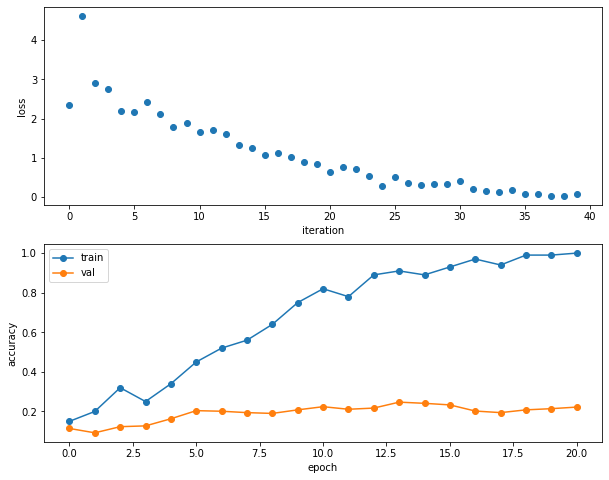

In [14]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

solver.record_histories_as_npz('submission_logs/overfit_3layer_cnn.npz')

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [15]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

solver.record_histories_as_npz('submission_logs/train_cnn_single_epoch.npz')

(Iteration 1 / 980) loss: 2.304614
(Epoch 0 / 1) train acc: 0.094000; val_acc: 0.119000
(Iteration 21 / 980) loss: 1.992294
(Iteration 41 / 980) loss: 2.546761
(Iteration 61 / 980) loss: 1.933910
(Iteration 81 / 980) loss: 2.208893
(Iteration 101 / 980) loss: 1.833975
(Iteration 121 / 980) loss: 1.805803
(Iteration 141 / 980) loss: 1.972540
(Iteration 161 / 980) loss: 1.668340
(Iteration 181 / 980) loss: 1.963807
(Iteration 201 / 980) loss: 1.630193
(Iteration 221 / 980) loss: 1.671712
(Iteration 241 / 980) loss: 1.556712
(Iteration 261 / 980) loss: 1.623724
(Iteration 281 / 980) loss: 1.652139
(Iteration 301 / 980) loss: 1.767816
(Iteration 321 / 980) loss: 1.698759
(Iteration 341 / 980) loss: 1.809675
(Iteration 361 / 980) loss: 1.668588
(Iteration 381 / 980) loss: 1.623190
(Iteration 401 / 980) loss: 1.626030
(Iteration 421 / 980) loss: 1.508523
(Iteration 441 / 980) loss: 1.617768
(Iteration 461 / 980) loss: 1.686032
(Iteration 481 / 980) loss: 1.628814
(Iteration 501 / 980) loss: 

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

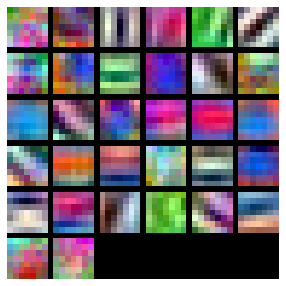

In [16]:
from deeplearning.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

# Spatial Batch Normalization
We already saw that batch normalization is a very useful technique for training deep fully-connected networks. Batch normalization can also be used for convolutional networks, but we need to tweak it a bit; the modification will be called "spatial batch normalization."

Normally batch-normalization accepts inputs of shape `(N, D)` and produces outputs of shape `(N, D)`, where we normalize across the minibatch dimension `N`. For data coming from convolutional layers, batch normalization needs to accept inputs of shape `(N, C, H, W)` and produce outputs of shape `(N, C, H, W)` where the `N` dimension gives the minibatch size and the `(H, W)` dimensions give the spatial size of the feature map.

If the feature map was produced using convolutions, then we expect the statistics of each feature channel to be relatively consistent both between different imagesand different locations within the same image. Therefore spatial batch normalization computes a mean and variance for each of the `C` feature channels by computing statistics over both the minibatch dimension `N` and the spatial dimensions `H` and `W`.

## Spatial batch normalization: forward

In the file `deeplearning/layers.py`, implement the forward pass for spatial batch normalization in the function `spatial_batchnorm_forward`. Check your implementation by running the following:

In [17]:
# Check the training-time forward pass by checking means and variances
# of features both before and after spatial batch normalization
N, C, H, W = 2, 3, 4, 5
x = 4 * np.random.randn(N, C, H, W) + 10

print ('Before spatial batch normalization:')
print ('  Shape: ', x.shape)
print ('  Means: ', x.mean(axis=(0, 2, 3)))
print ('  Stds: ', x.std(axis=(0, 2, 3)))

# Means should be close to zero and stds close to one. Shape should be unchanged.
gamma, beta = np.ones(C), np.zeros(C)
bn_param = {'mode': 'train'}
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print ('After spatial batch normalization:')
print ('  Shape: ', out.shape)
print ('  Means: ', out.mean(axis=(0, 2, 3)))
print ('  Stds: ', out.std(axis=(0, 2, 3)))

# Means should be close to beta and stds close to gamma. Shape should be unchnaged.
gamma, beta = np.asarray([3, 4, 5]), np.asarray([6, 7, 8])
out, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)
print ('After spatial batch normalization (nontrivial gamma, beta):')
print ('  Shape: ', out.shape)
print ('  Means: ', out.mean(axis=(0, 2, 3)))
print ('  Stds: ', out.std(axis=(0, 2, 3)))

Before spatial batch normalization:
  Shape:  (2, 3, 4, 5)
  Means:  [ 9.64204908 11.08842642 10.41366375]
  Stds:  [4.0823567  4.0832913  3.64298869]
After spatial batch normalization:
  Shape:  (2, 3, 5, 4)
  Means:  [-2.66453526e-16 -3.91006671e-16 -8.60422844e-17]
  Stds:  [0.9999997  0.9999997  0.99999962]
After spatial batch normalization (nontrivial gamma, beta):
  Shape:  (2, 3, 5, 4)
  Means:  [6. 7. 8.]
  Stds:  [2.9999991  3.9999988  4.99999812]


In [19]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, C, H, W = 10, 4, 11, 12

bn_param = {'mode': 'train'}
gamma = np.ones(C)
beta = np.zeros(C)
for t in range(50):
    x = 2.3 * np.random.randn(N, C, H, W) + 13
    spatial_batchnorm_forward(x, gamma, beta, bn_param)
bn_param['mode'] = 'test'
x = 2.3 * np.random.randn(N, C, H, W) + 13
a_norm, _ = spatial_batchnorm_forward(x, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print ('After spatial batch normalization (test-time):')
print ('  means: ', a_norm.mean(axis=(0, 2, 3)))
print ('  stds: ', a_norm.std(axis=(0, 2, 3)))

After spatial batch normalization (test-time):
  means:  [-0.0153102   0.05858677  0.01039065  0.04439104]
  stds:  [0.98825047 1.05649262 0.99298054 0.96830075]
